### Гопиенко Александр Дмитриевич КИ22-17/2Б

# Практическая работа №4 по реккурентным нейронным сетям

In [94]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from tqdm import tqdm 

In [95]:
ACTIVITIES = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING',
}

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [96]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI HAR dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        )

    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    filename = f'UCI HAR dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

def plot_train_val_test_accuracy_loss(history):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history['test_accuracy'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [97]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

X_train, X_test, Y_train, Y_test = load_data()
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

C:\Users\User\AppData\Local\Temp\ipykernel_13360\1454581712.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
C:\Users\User\AppData\Local\Temp\ipykernel_13360\1454581712.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
C:\Users\User\AppData\Local\Temp\ipykernel_13360\1454581712.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
C:\Users\User\AppData\Local\Temp\ipykernel_13360\1454581712.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future ve

In [98]:
print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


### Датасет

In [99]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = CustomDataset(X_train, Y_train)
test_dataset = CustomDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# RNN

In [100]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, n_classes):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  
        out = self.fc(out)
        return out

# LSTM

In [101]:
class LstmClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, n_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# GRU

In [102]:
class GruClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, n_classes):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Bidirectional RNN

In [103]:
class BRnnClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, n_classes):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, n_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [104]:
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        y = torch.argmax(y, dim=1)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / total
    return avg_loss, avg_acc


In [105]:
def evaluate(model, criterion, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            y = torch.argmax(y, dim=1)

            outputs = model(X)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(val_loader)
    avg_acc = correct / total
    return avg_loss, avg_acc

In [106]:
def evaluate_test(model, criterion, test_loader, device):
    return evaluate(model, criterion, test_loader, device)

In [107]:
def objective(trial, model_option="rnn"):
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_categorical('lr', [1e-4, 1e-3, 1e-2])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])

    if model_option == "rnn":
        model = RNNClassifier(input_dim, hidden_dim, num_layers, n_classes).to(device)
    elif model_option == "lstm":
        model = LstmClassifier(input_dim, hidden_dim, num_layers, n_classes).to(device)
    elif model_option == "gru":
        model = GruClassifier(input_dim, hidden_dim, num_layers, n_classes).to(device)
    elif model_option == "brnn":
        model = BRnnClassifier(input_dim, hidden_dim, num_layers, n_classes).to(device)

    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [], 'val_loss': [], 'test_loss': [],
        'train_accuracy': [], 'val_accuracy': [], 'test_accuracy': []
    }

    best_val_loss = float('inf')
    best_val_accuracy = 0.0 
    patience = 5
    counter = 0

    for epoch in tqdm(range(10), desc="Training"):
        train_loss, train_acc = train(model, optimizer, criterion, train_loader, device)
        val_loss, val_acc = evaluate(model, criterion, test_loader, device)  
        test_loss, test_acc = evaluate_test(model, criterion, test_loader, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['test_loss'].append(test_loss)

        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['test_accuracy'].append(test_acc)

        trial.report(val_loss, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_acc  
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping on epoch {epoch}")
                break

        if trial.should_prune():
            raise optuna.TrialPruned()

    trial.set_user_attr('history', history)
    trial.set_user_attr('best_val_accuracy', best_val_accuracy)  

    return best_val_loss


# RNN

[I 2025-04-26 19:58:54,195] A new study created in memory with name: no-name-ad0eebbd-40de-48a4-ba38-952160bafa8f
Training: 100%|██████████| 10/10 [02:13<00:00, 13.34s/it]
[I 2025-04-26 20:01:07,566] Trial 0 finished with value: 1.4675237866499091 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'lr': 0.01, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.4675237866499091.
Training: 100%|██████████| 10/10 [02:01<00:00, 12.17s/it]
[I 2025-04-26 20:03:09,248] Trial 1 finished with value: 1.0905508078554624 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'lr': 0.01, 'optimizer': 'SGD'}. Best is trial 1 with value: 1.0905508078554624.
Training: 100%|██████████| 10/10 [02:17<00:00, 13.71s/it]
[I 2025-04-26 20:05:26,345] Trial 2 finished with value: 1.058914676268575 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'lr': 0.0001, 'optimizer': 'Adam'}. Best is trial 2 with value: 1.058914676268575.
Training:  60%|██████    | 6/10 [00:58<00:39,  9.80s/it]
[I 2025-04-26 20:06:25,17

Early stopping on epoch 6


Training: 100%|██████████| 10/10 [02:23<00:00, 14.38s/it]
[I 2025-04-26 20:08:48,971] Trial 4 finished with value: 1.7880379333291003 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'lr': 0.0001, 'optimizer': 'SGD'}. Best is trial 2 with value: 1.058914676268575.


Best params: {'hidden_dim': 128, 'num_layers': 2, 'lr': 0.0001, 'optimizer': 'Adam'}
Best val_loss: 1.058914676268575
Best val_accuracy: 0.6155412283678316


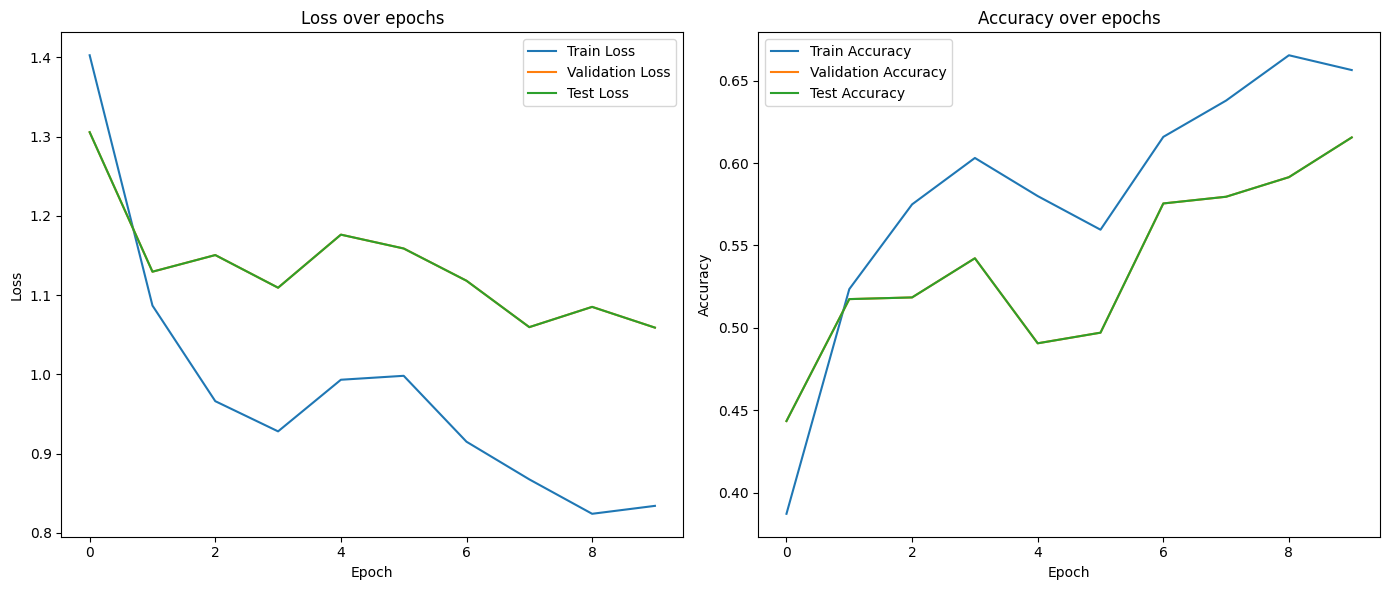

In [108]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, model_option="rnn"), n_trials=5)

print("Best params:", study.best_params)
print("Best val_loss:", study.best_value)
print("Best val_accuracy:", study.best_trial.user_attrs['best_val_accuracy'])

best_trial = study.best_trial
history = best_trial.user_attrs['history']
plot_train_val_test_accuracy_loss(history)


# LSTM

[I 2025-04-26 20:08:49,268] A new study created in memory with name: no-name-f3a4ecdd-8788-4382-8707-710467a63417
Training: 100%|██████████| 10/10 [01:07<00:00,  6.77s/it]
[I 2025-04-26 20:09:56,998] Trial 0 finished with value: 0.3356860989081343 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'lr': 0.01, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3356860989081343.
Training:  80%|████████  | 8/10 [00:57<00:14,  7.24s/it]
[I 2025-04-26 20:10:54,935] Trial 1 finished with value: 0.31782449162327336 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'lr': 0.01, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.31782449162327336.


Early stopping on epoch 8


Training: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it]
[I 2025-04-26 20:11:31,014] Trial 2 finished with value: 1.237912471816745 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'lr': 0.0001, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.31782449162327336.
Training: 100%|██████████| 10/10 [03:06<00:00, 18.61s/it]
[I 2025-04-26 20:14:37,128] Trial 3 finished with value: 1.7839784827283633 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'lr': 0.01, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.31782449162327336.
Training:  60%|██████    | 6/10 [02:49<01:53, 28.28s/it]
[I 2025-04-26 20:17:26,840] Trial 4 finished with value: 0.8323186049538274 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'lr': 0.001, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.31782449162327336.


Early stopping on epoch 6
Best params: {'hidden_dim': 128, 'num_layers': 1, 'lr': 0.01, 'optimizer': 'Adam'}
Best score: 0.31782449162327336
Best val_accuracy: 0.8937902952154734


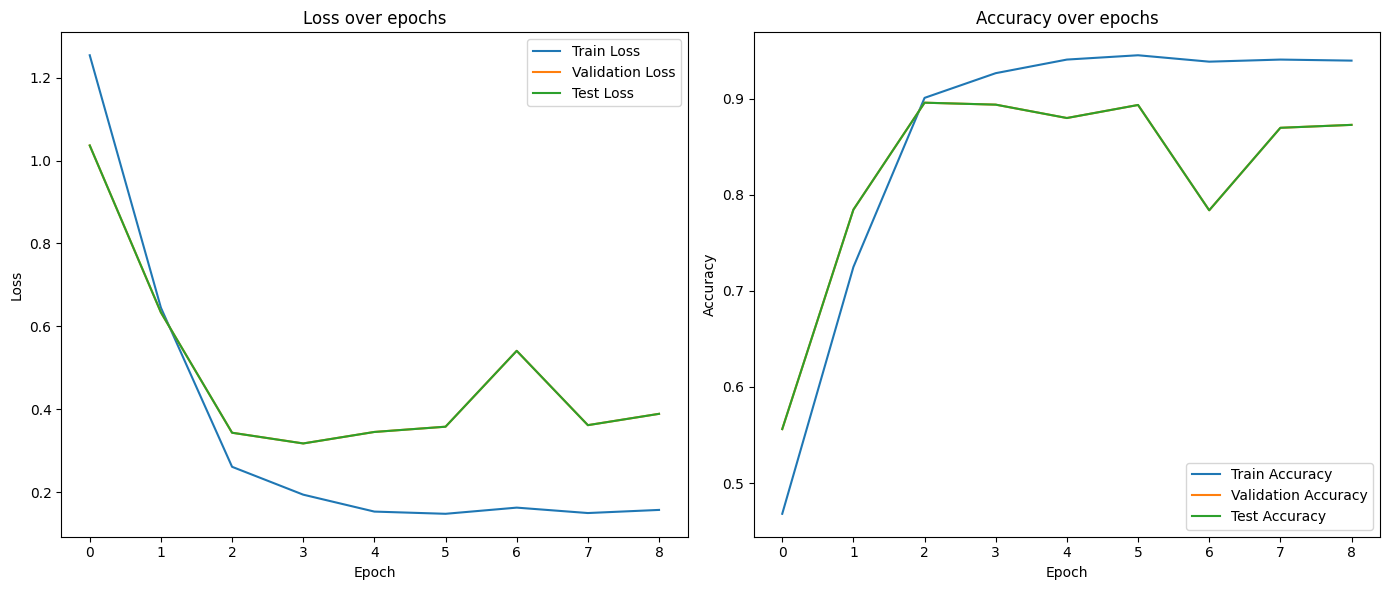

In [109]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, model_option="lstm"), n_trials=5)

print("Best params:", study.best_params)
print("Best score:", study.best_value)
print("Best val_accuracy:", study.best_trial.user_attrs['best_val_accuracy'])

best_trial = study.best_trial
history = best_trial.user_attrs['history']
plot_train_val_test_accuracy_loss(history)

# GRU

[I 2025-04-26 20:17:27,180] A new study created in memory with name: no-name-f814120b-56b2-4481-88db-9dd4ffc0620f
Training: 100%|██████████| 10/10 [06:05<00:00, 36.54s/it]
[I 2025-04-26 20:23:32,561] Trial 0 finished with value: 1.7590770388162265 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'lr': 0.001, 'optimizer': 'SGD'}. Best is trial 0 with value: 1.7590770388162265.
Training: 100%|██████████| 10/10 [06:36<00:00, 39.62s/it]
[I 2025-04-26 20:30:08,732] Trial 1 finished with value: 1.763586603185182 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'lr': 0.001, 'optimizer': 'SGD'}. Best is trial 0 with value: 1.7590770388162265.
Training: 100%|██████████| 10/10 [04:20<00:00, 26.05s/it]
[I 2025-04-26 20:34:29,288] Trial 2 finished with value: 0.7071960430632356 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'lr': 0.0001, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7071960430632356.
Training: 100%|██████████| 10/10 [03:35<00:00, 21.56s/it]
[I 2025-04-26 20:38:04,

Best params: {'hidden_dim': 32, 'num_layers': 2, 'lr': 0.001, 'optimizer': 'Adam'}
Best score: 0.41467398810150324
Best val_accuracy: 0.8683406854428232


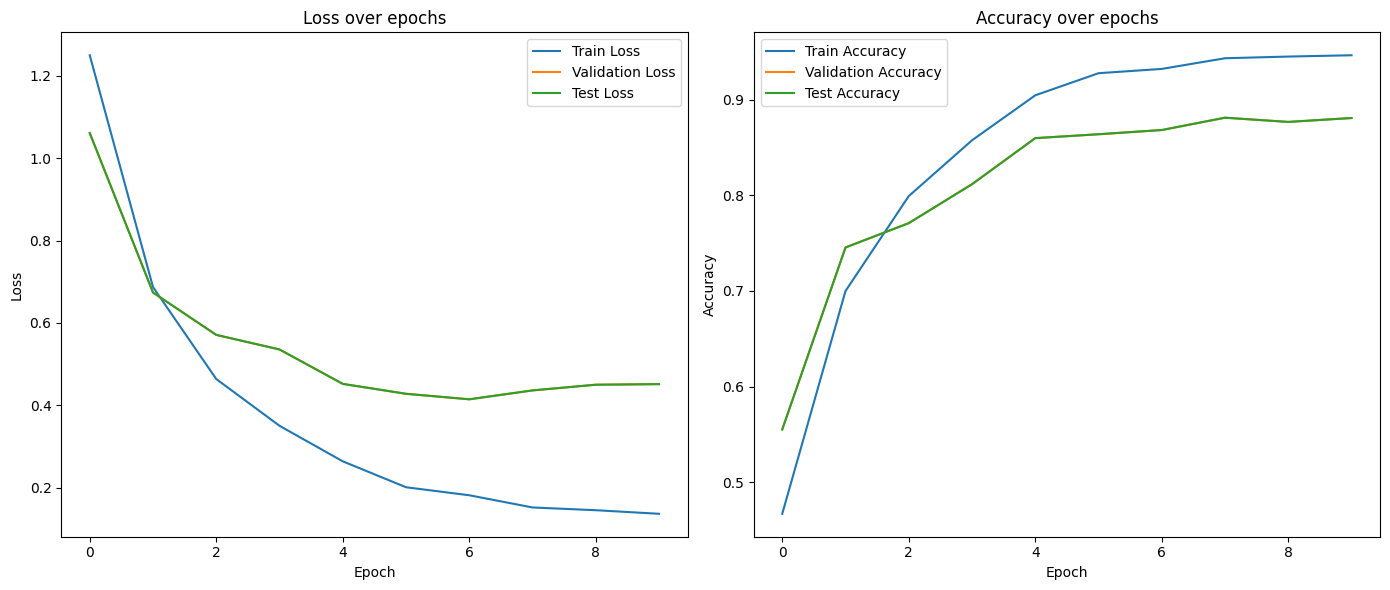

In [110]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, model_option="gru"), n_trials=5) 

print("Best params:", study.best_params)
print("Best score:", study.best_value)
print("Best val_accuracy:", study.best_trial.user_attrs['best_val_accuracy'])

best_trial = study.best_trial
history = best_trial.user_attrs['history']
plot_train_val_test_accuracy_loss(history)

# Bidirectional RNN

[I 2025-04-26 20:42:15,954] A new study created in memory with name: no-name-850ec926-a538-46c8-8822-dcc041a2a924
Training: 100%|██████████| 10/10 [08:43<00:00, 52.37s/it]
[I 2025-04-26 20:50:59,632] Trial 0 finished with value: 0.8995556135371487 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'lr': 0.01, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8995556135371487.
Training: 100%|██████████| 10/10 [04:46<00:00, 28.65s/it]
[I 2025-04-26 20:55:46,172] Trial 1 finished with value: 1.0456896614163154 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'lr': 0.01, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8995556135371487.
Training: 100%|██████████| 10/10 [07:29<00:00, 44.91s/it]
[I 2025-04-26 21:03:15,259] Trial 2 finished with value: 1.3153510612826194 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'lr': 0.001, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8995556135371487.
Training: 100%|██████████| 10/10 [03:13<00:00, 19.33s/it]
[I 2025-04-26 21:06:28,6

Best params: {'hidden_dim': 128, 'num_layers': 3, 'lr': 0.0001, 'optimizer': 'Adam'}
Best score: 0.6394266263451628
Best val_accuracy: 0.7265015269765863


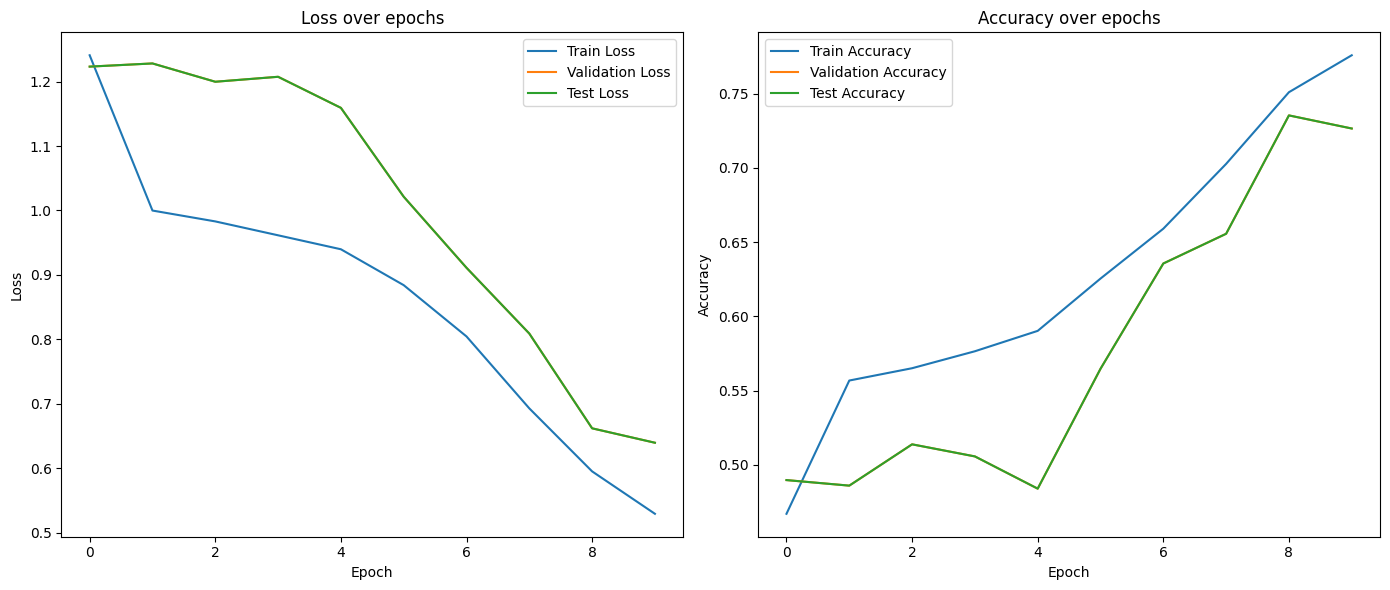

In [111]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, model_option="brnn"), n_trials=5)

print("Best params:", study.best_params)
print("Best score:", study.best_value)
print("Best val_accuracy:", study.best_trial.user_attrs['best_val_accuracy'])

best_trial = study.best_trial
history = best_trial.user_attrs['history']
plot_train_val_test_accuracy_loss(history)